In [253]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [254]:
df = pd.read_csv('GOOG.csv')
df.head()
df.dtypes

symbol          object
date            object
close          float64
high           float64
low            float64
open           float64
volume           int64
adjClose       float64
adjHigh        float64
adjLow         float64
adjOpen        float64
adjVolume        int64
divCash        float64
splitFactor    float64
dtype: object

In [255]:
def str_to_datetime(s):
    split = s.split(' ')
    split1 = split[0].split('-')
    year, month, day = int(split1[0]), int(split1[1]), int(split1[2])
    return datetime.datetime(year = year, month = month, day = day)

In [256]:
df['date'] = df['date'].apply(str_to_datetime)
df['date']

0      2016-06-14
1      2016-06-15
2      2016-06-16
3      2016-06-17
4      2016-06-20
          ...    
1253   2021-06-07
1254   2021-06-08
1255   2021-06-09
1256   2021-06-10
1257   2021-06-11
Name: date, Length: 1258, dtype: datetime64[ns]

In [259]:
df = df.sort_values('date')

scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = scaler.fit_transform(df[['close']])

In [260]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [261]:
seq_length = 10
data = df['close'].values
X, y = create_sequences(data, seq_length)

In [262]:
dates = df['date'][seq_length:]
q_75 = int(len(dates) * 0.75)
dates_train, X_train, y_train = dates[:q_75], X[:q_75], y[:q_75]
dates_test, X_test, y_test = dates[q_75:], X[q_75:], y[q_75:]

In [263]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [264]:
model = Sequential([layers.Input(shape = (seq_length, 1)),
                    layers.LSTM(64, return_sequences=True),
                    layers.Dropout(0.2),
                    layers.LSTM(64),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [265]:
history = model.fit(X_train, y_train,
                    batch_size=32, 
                    epochs=100)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/100


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0275 - mean_absolute_error: 0.1351
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mean_absolute_error: 0.0405
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6186e-04 - mean_absolute_error: 0.0227
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4053e-04 - mean_absolute_error: 0.0184
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2325e-04 - mean_absolute_error: 0.0165
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9450e-04 - mean_absolute_error: 0.0173
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6416e-04 - mean_absolute_error: 0.0155
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3755e-04 - mean_absolute_error: 0.0167
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5531e-04 - mean_absolute_error: 0.0157
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7371e-04 - mean_absolute_error: 0.0156
Epoch 11/

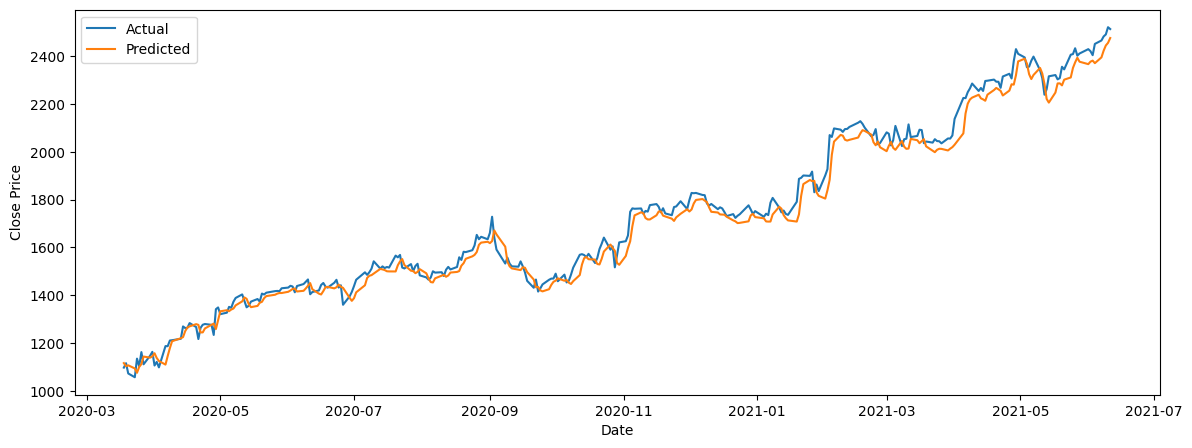

In [266]:
actual_values = scaler.inverse_transform(df['close'].values[q_75 + seq_length:].reshape(-1, 1))
plot_dates = dates[q_75:].reset_index(drop=True)
plt.figure(figsize=(14, 5))
plt.plot(plot_dates, actual_values, label='Actual')
plt.plot(plot_dates, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

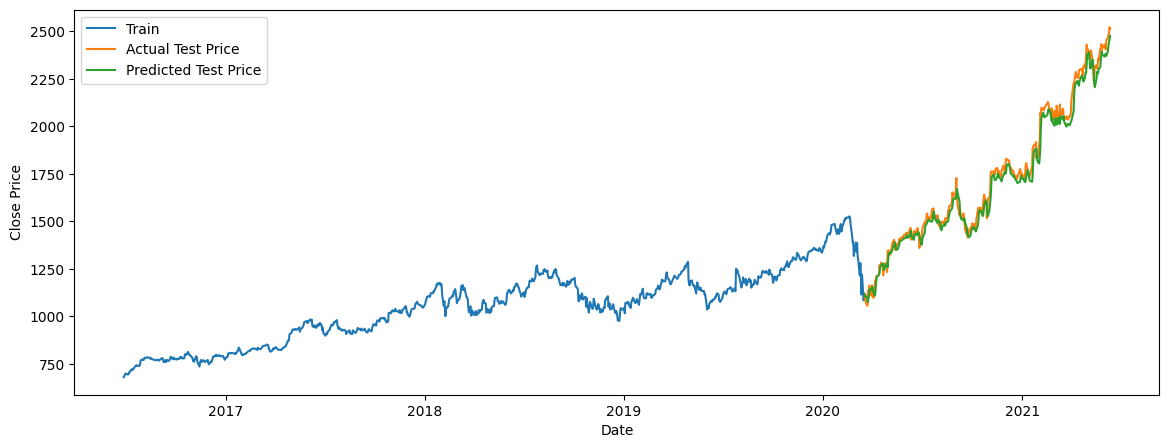

In [268]:
plt.figure(figsize=(14, 5))
plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)), label='Train')
plt.plot(plot_dates, actual_values, label='Actual Test Price')
plt.plot(plot_dates, predictions, label='Predicted Test Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()